<a href="https://colab.research.google.com/github/mariuszknowak-experiments/binary-option-market-public/blob/main/Binary_option_market_equilibrium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Option Market Equilibrium
A Binary option is a security which pays 1 if some event happens, and 0 otherwise.

Therefore if we use p to denote the probability of that event happening, the value of such option at expire is distributed according to the Bernoulli(p) probability distribution (for the purpose of this notebook we neglect the interest rate and assume that the event on which we are betting is uncorrelated with the investor portfolio).

A betting market (or equivalently, the binary option market), is a way to extract the wisdom of the crowds from financially motivated agents. Ideally, the price of the binary option should equal the best estimate of the probability that the event is going to occur.

In this notebook I examine the binary option market in equilibrium, and test whether we can indeed expect the price of the binary option to reflect the best estimate of the probability that the event will take place.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm


#Beta Distribution

Beta(a,b) probability distribution is the conjugate prior of Bernoulli(p) probability distribution. Broadly speaking, it means that if the observer's prior probability distribution over p is Beta, then the posterior probability distribution (i.e. probability distribution given some new data) is also Beta.

Let's make it more specific:

Suppose that the event we are interested in is a coin toss. The coin lands heads up with probability p. Now, let's take a bayesian observer whose prior probability distribution over p is Beta(a,b). If the observer witnesses j events in which coin came up tails and k events in which the coin came up heads, then his posterior probability distribution over p, given that events, will be Beta(a+j,b+k).

Given that Beta i the conjugate prior of Bernoulli, it is reasonable to model the beliefs of market participants about probability of the event occuring (or equivalently,the binary option having value of 1 at expiry) as Beta.

Below you can see histograms of random variables distributed according to Beta(a,b) for different values of parameters.

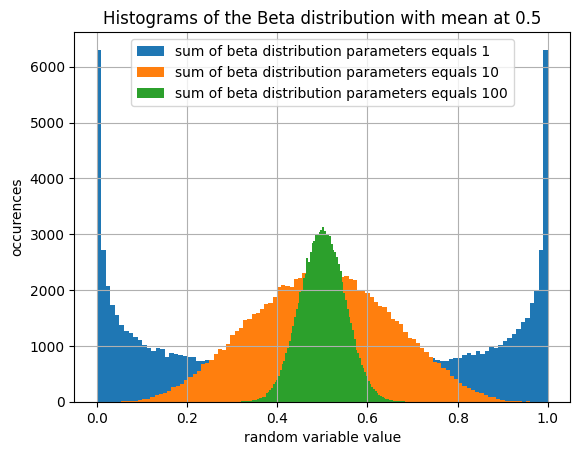

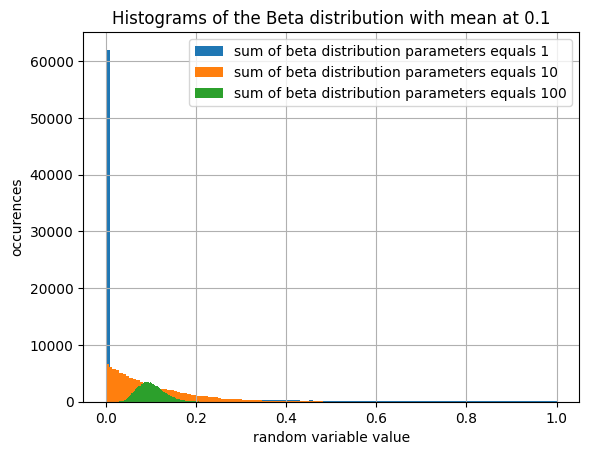

In [ ]:
plt.hist(np.random.beta(0.5,0.5,int(1e5)),bins=100, label='sum of beta distribution parameters equals 1');
plt.hist(np.random.beta(5,5,int(1e5)),bins=100, label='sum of beta distribution parameters equals 10');
plt.hist(np.random.beta(50,50,int(1e5)),bins=100, label='sum of beta distribution parameters equals 100');
plt.xlabel('random variable value')
plt.ylabel('occurences')
plt.title('Histograms of the Beta distribution with mean at 0.5')
plt.grid()
plt.legend()
plt.show()


plt.figure()
plt.hist(np.random.beta(0.1,0.9,int(1e5)),bins=100, label='sum of beta distribution parameters equals 1');
plt.hist(np.random.beta(1,9,int(1e5)),bins=100, label='sum of beta distribution parameters equals 10');
plt.hist(np.random.beta(10,90,int(1e5)),bins=100, label='sum of beta distribution parameters equals 100');
plt.xlabel('random variable value')
plt.ylabel('occurences')
plt.title('Histograms of the Beta distribution with mean at 0.1')
plt.grid()
plt.legend()
plt.show()

#Problem: Beta distribution is not necessarily symmetrical
As you can see in the figure above, the Beta distribution is not necessarily symmetrical round its mean. This means that the mean and median of the distribution will be differerent. You may ask why does it matter. In this notebook we want to explore whether the binary option market can extract the 'wisdom of the crowds' from market participants. If every market participant buys the binary option if the price is below his probability estimate and sells it if it is above his probability estimate, and he always trades for the same amount of money, then the resulting market price (price at which there is an equal number buy andd sell orders) will be the median of the distribution of beliefs among market participants, not its mean.



#How much should one bet?

A market participant should buy the binary option if its price is lower than his estimate of the probability of the event and sell the option if the price is higher than that estimate. The question remains, how much of his capital he should commit.

One possibility, is to always bet the same amount - this method is implemented here as the naive_bet_size function.

However, there is a superior way of betting, namely the Kelly criterion (https://en.wikipedia.org/wiki/Kelly_criterion). If the market participant aims to maximize the logarithm of the expected wealth (which ie equivalent to maximizing the long term growth rate of wealth), then he should use the Kelly criterion. It is the way to optimally size the bet, given the price of the binary option and probability of the event.

In [ ]:
def kelly_criterion(probability, binary_option_price):
  odds=(1-binary_option_price)/(binary_option_price)
  return (probability- (1-probability)/odds)

def naive_bet_size(market_participants_beliefs,binary_option_price):
  #return np.tanh(1e6*(market_participants_beliefs-binary_option_price))
  return np.sign(market_participants_beliefs-binary_option_price)
  #return 2*(market_participants_beliefs>binary_option_price)-1


In [ ]:
def kelly_net_bets_in_market(market_participants_beliefs,binary_option_price):
  return np.mean(kelly_criterion(market_participants_beliefs,binary_option_price))

def non_kelly_net_bets_in_market(market_participants_beliefs,binary_option_price):
  return np.mean(naive_bet_size(market_participants_beliefs,binary_option_price))

#What should be the market-equilibrium price of a binary option?
The market exists, so that buyers can buy, and sellers can sell :).
We say that the market is in equilibrium, if the market price is such, that there is an equal number of buy and sell orders. Below, you can see the function equilibrium_price, which finds the market price of the option, by numerically minimizing the square of the net value of orders in the market (value of buy orders minus the value of sell orders). It assumes there are 3 types of market participants - market participants who bet according to Kelly criterion, market participants who always bet the same amount (buy when price is lower than their probability estimate, sell when it is higher), and external "net buyer" whom we can specify to commit some predetermined capital to the trade either by buying or by selling. The probability estimates for both the kelly and non-kelly market participants are sampled from the same prior probability distribution.


In [ ]:


def equilibrium_price(market_participants_beliefs, fraction_dict):
  total_fractions=sum(fraction_dict.values())*1.0
  for key in fraction_dict.keys():
    fraction_dict[key]/=total_fractions
    #print(fraction_dict)
  def net_buyers_in_market(price):
    return fraction_dict['kelly']*kelly_net_bets_in_market(market_participants_beliefs,price)+fraction_dict['non_kelly']*non_kelly_net_bets_in_market(market_participants_beliefs,price)+fraction_dict['net_buyer']

  return scipy.optimize.minimize(lambda price: np.square(net_buyers_in_market(price)),0.5,tol=1e-20,bounds=scipy.optimize.Bounds(1e-10,1-1e-10)).x[0]

#Time for the experiments!
As I stated previously, the main goal of this notebook is to explore to what extent we can extract wisdom of the crowds from market participants. So let's check what would be the market equilibrium price of the binary option if we vary the following parameters:


*   Sum of a and b parameters of Beta(a,b) distribution of beliefs among market participants
*   Mean of the distribution of beliefs among market participants
*   Fraction of the capital int the trade coming from participants betting in the naive (non-kelly) way




In [ ]:
non_kelly_frac_array=np.linspace(0,0.999,11)
ab_sum_list=[1,10,100]
super_result_dict=dict()
for ab_sum in tqdm(ab_sum_list):
  a_frac=np.linspace(0.01,0.49,10)
  a_arr=ab_sum*a_frac
  b_arr=ab_sum*(1-a_frac)
  super_result_dict[ab_sum]=dict()
  for a,b in tqdm(zip(a_arr,b_arr)):
    market_participants_beliefs=np.random.beta(a,b,int(1e4))
    result_list=list()
    for el in non_kelly_frac_array:

      fraction_dict={'kelly':1-el,'non_kelly':el,'net_buyer':0}
      result_dict=fraction_dict
      result_dict['equilibrium_price']=equilibrium_price(market_participants_beliefs,fraction_dict)
      result_dict['mean']=np.mean(market_participants_beliefs)
      result_dict['median']=np.median(market_participants_beliefs)
      result_list.append(result_dict)
    super_result_dict[ab_sum][(a,b)]=result_list










  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
market_participants_beliefs=np.random.beta(1,9,int(1e3))
fraction_dict={'kelly':0,'non_kelly':0.9,'net_buyer':0}
equilibrium_price(market_participants_beliefs,fraction_dict)

0.5

In [ ]:
np.exp(0.5)

1.6487212707001282

In [ ]:

scipy.optimize.minimize(lambda price: np.square(non_kelly_net_bets_in_market(market_participants_beliefs,price)),0.5,tol=1e-20,bounds=scipy.optimize.Bounds(1e-10,1-1e-10),method='Powell')

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.6e-05
       x: [ 7.232e-02]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 105

#What happens when all market participants are betting according to Kelly criterion?
Let's look at the results of the experiments, at first we should analyze what happens if all the market participants use Kelly criterion. The table below, shows that under such conditions, the equilibrium price is extremely close to the mean of the distribution of beliefs of market participants. It was quite surprising to me, but we can say that under our assumptions, **for Kelly-optimal betting, the binary option market effectively extracts the wisdom of the crowds from the market participants**.

In [ ]:
kelly_only_list=list()
for key in  super_result_dict.keys():
  for key2 in super_result_dict[key].keys():
    row=pd.DataFrame(super_result_dict[key][key2])[pd.DataFrame(super_result_dict[key][key2])['kelly']==1].iloc[0]
    row['beta_params']=key2
    kelly_only_list.append(row)


pd.DataFrame(kelly_only_list)[['beta_params','kelly','non_kelly','equilibrium_price','mean','median']]

,beta_params,kelly,non_kelly,equilibrium_price,mean,median
0,"(0.01, 0.99)",1.0,0.0,0.009435,0.009435,1.474189e-30
0,"(0.06333333333333332, 0.9366666666666666)",1.0,0.0,0.059834,0.059834,1.455032e-05
0,"(0.11666666666666665, 0.8833333333333333)",1.0,0.0,0.115298,0.115298,2.982897e-03
0,"(0.16999999999999998, 0.8300000000000001)",1.0,0.0,0.168444,0.168444,2.451475e-02
0,"(0.22333333333333333, 0.7766666666666666)",1.0,0.0,0.225302,0.225302,6.662243e-02
0,"(0.27666666666666667, 0.7233333333333334)",1.0,0.0,0.274956,0.274956,1.229238e-01
0,"(0.32999999999999996, 0.67)",1.0,0.0,0.328745,0.328745,2.018711e-01
0,"(0.3833333333333333, 0.6166666666666667)",1.0,0.0,0.383301,0.383301,2.881151e-01
0,"(0.43666666666666665, 0.5633333333333334)",1.0,0.0,0.440018,0.440018,3.929247e-01
0,"(0.49, 0.51)",1.0,0.0,0.493956,0.493956,4.900979e-01


#What happens when (almost) all market participants are betting naively?
Let's look at the results of the experiments, at first we should analyze what happens if all the market participants use Kelly criterion. The table below, shows that under such conditions, the equilibrium price is extremely close to the mean of the distribution of beliefs of market participants. It was quite surprising to me, but we can say that under our assumptions, for Kelly-optimal betting, the binary option market effectively extracts the wisdom of the crowds from the market participants.

In [ ]:
non_kelly_only_list=list()
for key in  super_result_dict.keys():
  for key2 in super_result_dict[key].keys():
    row=pd.DataFrame(super_result_dict[key][key2])[np.square(pd.DataFrame(super_result_dict[key][key2])['kelly']-0.0010)<0.000001].iloc[0]
    row['beta_params']=key2
    non_kelly_only_list.append(row)



pd.DataFrame(non_kelly_only_list)[['beta_params','kelly','non_kelly','equilibrium_price','mean','median']]

,beta_params,kelly,non_kelly,equilibrium_price,mean,median
10,"(0.01, 0.99)",0.001,0.999,1.000000e-10,0.009435,1.474189e-30
10,"(0.06333333333333332, 0.9366666666666666)",0.001,0.999,1.455032e-05,0.059834,1.455032e-05
10,"(0.11666666666666665, 0.8833333333333333)",0.001,0.999,2.989468e-03,0.115298,2.982897e-03
10,"(0.16999999999999998, 0.8300000000000001)",0.001,0.999,2.451595e-02,0.168444,2.451475e-02
10,"(0.22333333333333333, 0.7766666666666666)",0.001,0.999,6.662360e-02,0.225302,6.662243e-02
10,"(0.27666666666666667, 0.7233333333333334)",0.001,0.999,1.229335e-01,0.274956,1.229238e-01
10,"(0.32999999999999996, 0.67)",0.001,0.999,2.019701e-01,0.328745,2.018711e-01
10,"(0.3833333333333333, 0.6166666666666667)",0.001,0.999,2.881730e-01,0.383301,2.881151e-01
10,"(0.43666666666666665, 0.5633333333333334)",0.001,0.999,3.930440e-01,0.440018,3.929247e-01
10,"(0.49, 0.51)",0.001,0.999,4.901823e-01,0.493956,4.900979e-01


# Let's see what happens when some market participants are naive (they are not betting according to Kelly criterion)

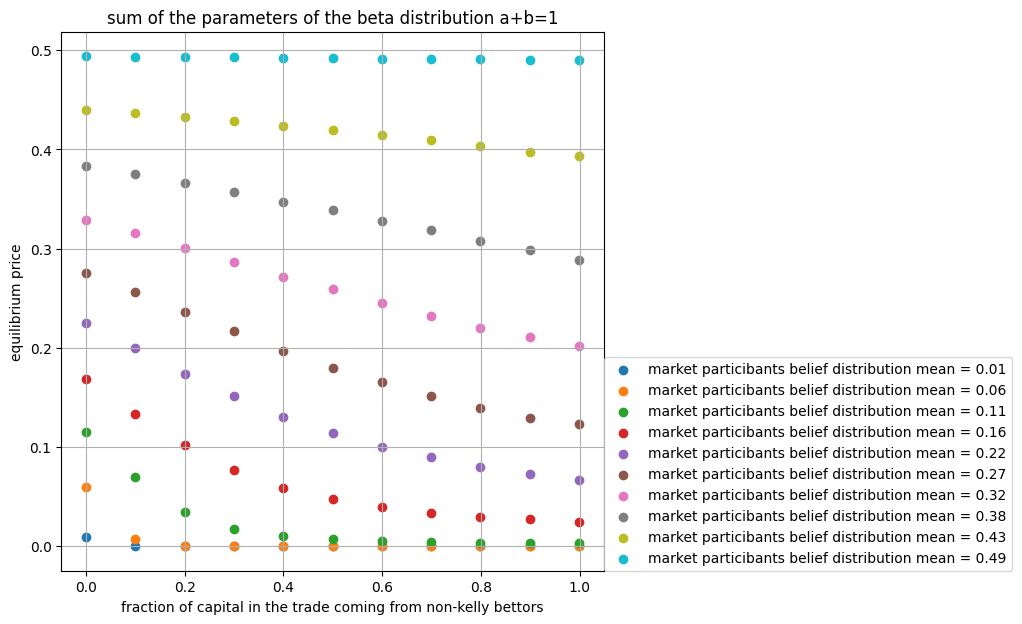

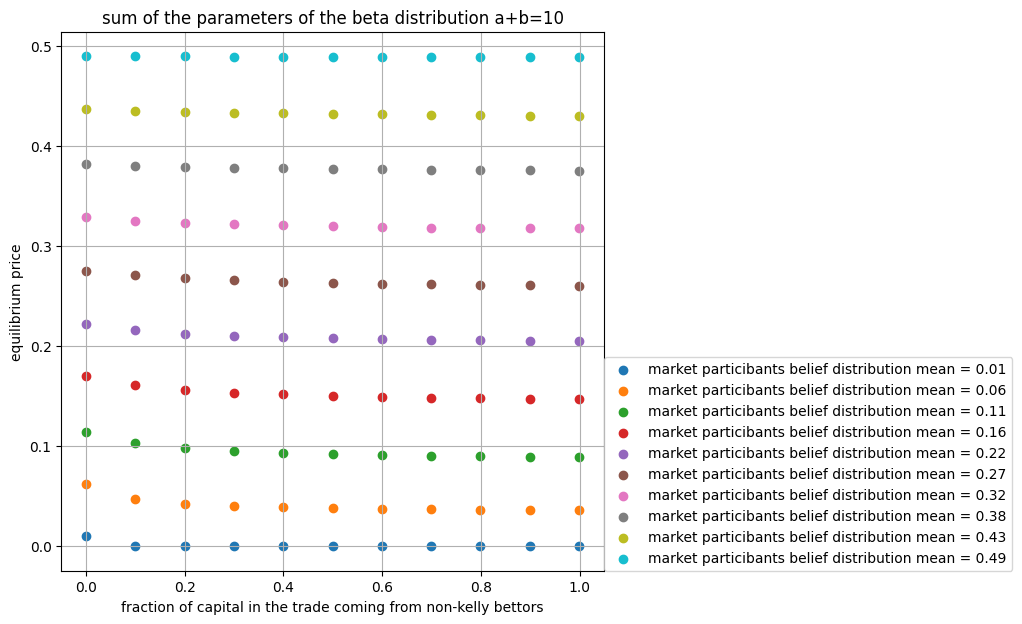

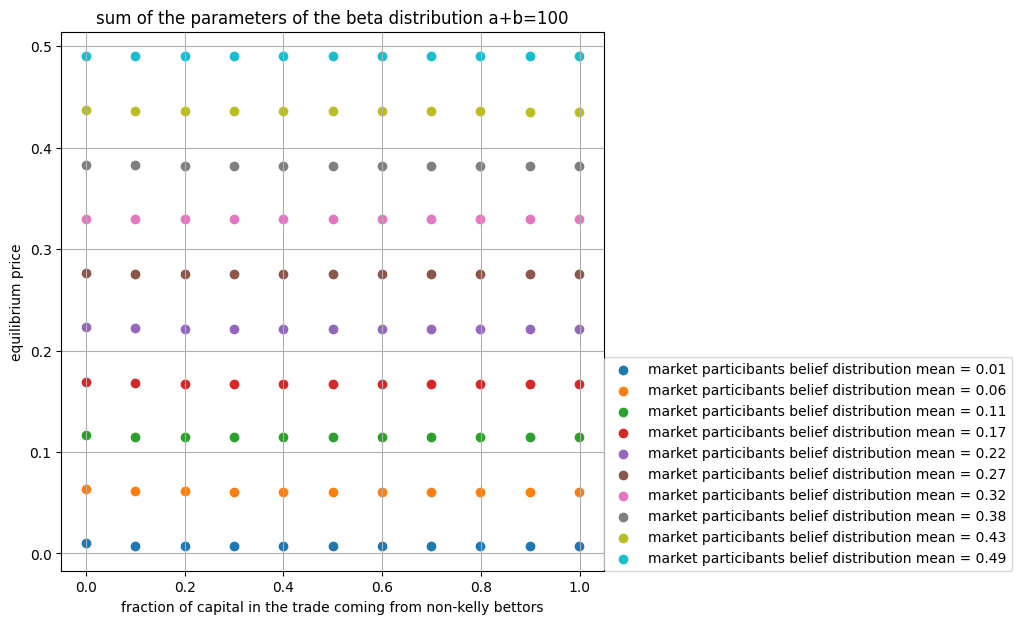

In [ ]:
for key in  super_result_dict.keys():
  plt.figure(figsize=(7,7))
  plt.title("sum of the parameters of the beta distribution a+b="+str(key))
  for key2 in super_result_dict[key].keys():
    super_result_dict[key][key2]=pd.DataFrame(super_result_dict[key][key2])
    plt.scatter(super_result_dict[key][key2]['non_kelly'],super_result_dict[key][key2]['equilibrium_price'],label='market particibants belief distribution mean = '+str(key2[0]/(key2[0]+key2[1]))[:4])
  plt.legend(loc=(1,0))
  plt.xlabel('fraction of capital in the trade coming from non-kelly bettors')
  plt.ylabel('equilibrium price')
  plt.grid()
  plt.show()
  print('\n\n')


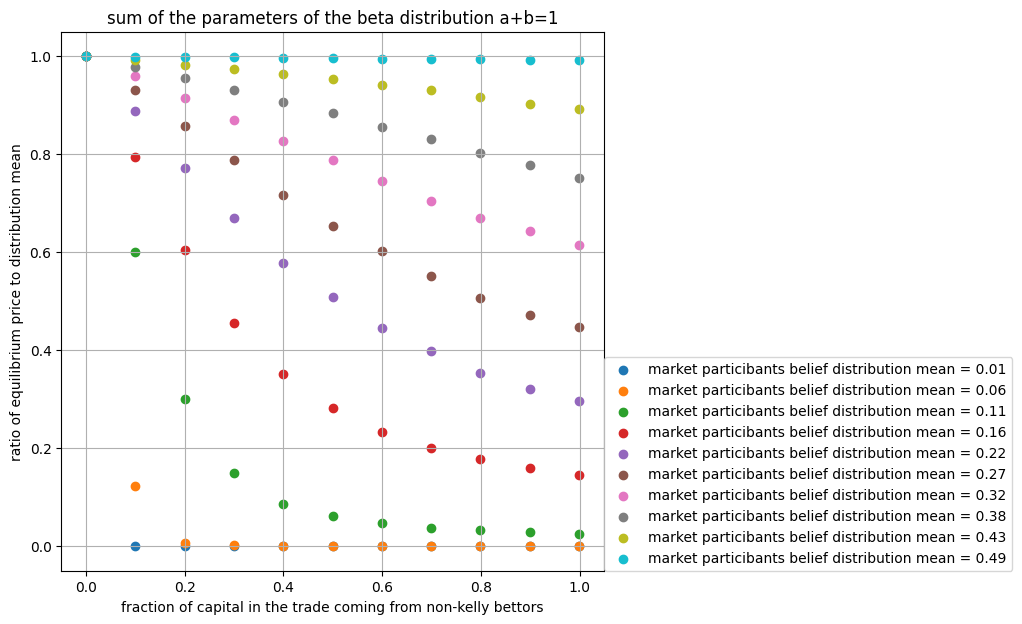

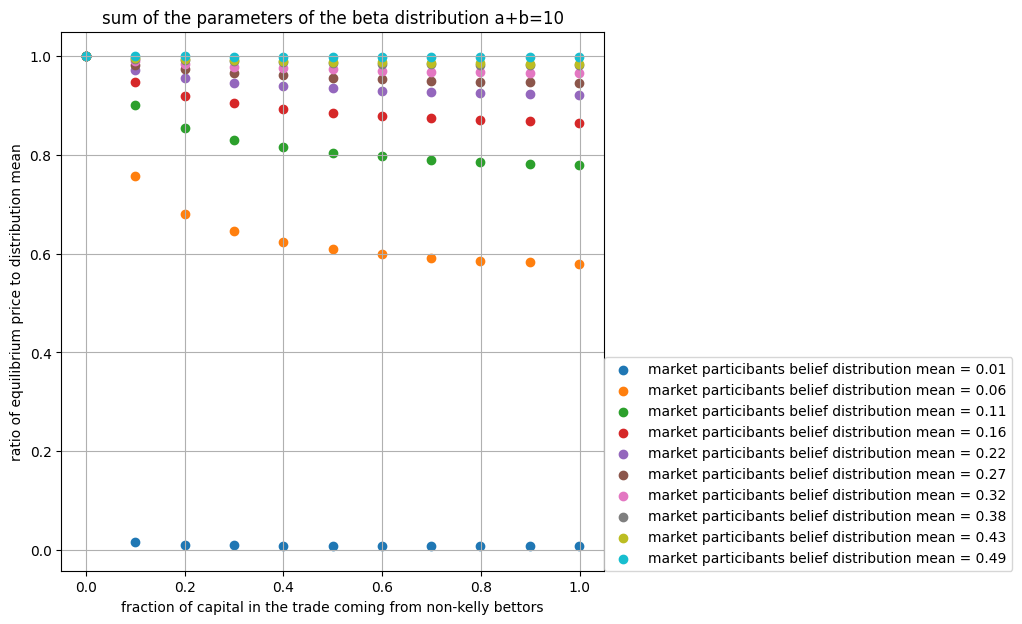

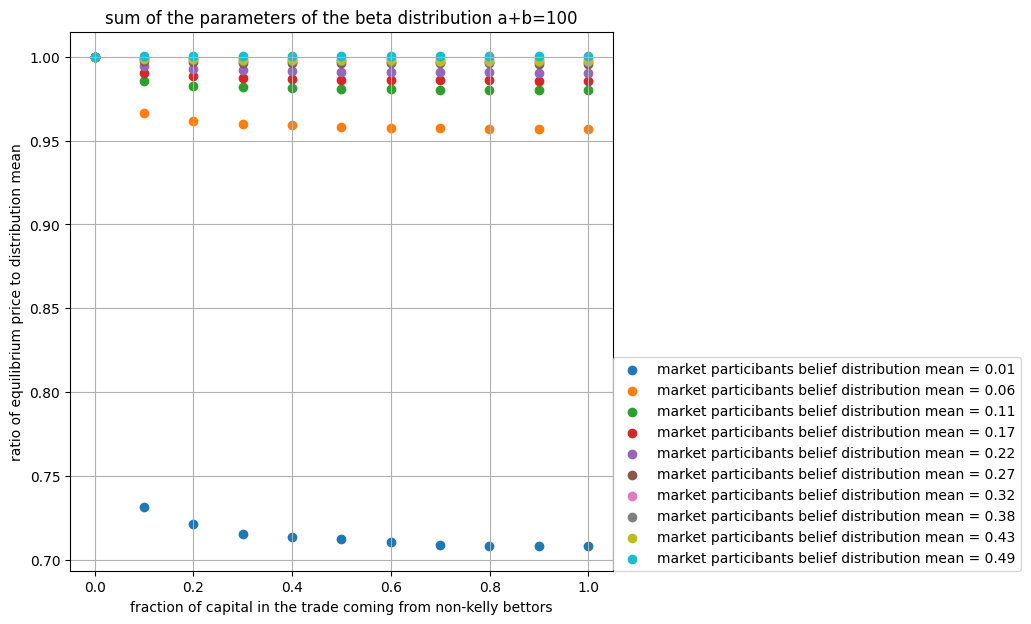

In [ ]:
for key in  super_result_dict.keys():
  plt.figure(figsize=(7,7))
  plt.title("sum of the parameters of the beta distribution a+b="+str(key))
  for key2 in super_result_dict[key].keys():
    super_result_dict[key][key2]=pd.DataFrame(super_result_dict[key][key2])
    plt.scatter(super_result_dict[key][key2]['non_kelly'],super_result_dict[key][key2]['equilibrium_price']/super_result_dict[key][key2]['mean'],label='market particibants belief distribution mean = '+str(key2[0]/(key2[0]+key2[1]))[:4])
  plt.legend(loc=(1,0))
  plt.xlabel('fraction of capital in the trade coming from non-kelly bettors')
  plt.ylabel('ratio of equilibrium price to distribution mean')
  plt.grid()
  plt.show()
  print('\n\n')

#Non-Kelly bettors change the market dramatically!

As you can see in the plots above, when all market participants bet according to Kelly criterion, the equilibrium market price is the mean of their beliefs about the probability of the event, but the addition of non-kelly bettors causes the equilibrium market price to diverge very quickly. This effect is more pronounced for low probability events and for belief distributions with high sum of Beta distribution  parameters.
**Moreover, when too much of the capital in the trade comes from non-kelly bettors, the market fails spectacularly - price of the security approaches infinitesimally close to 0.** In practice, it means that there are more sellers than buyers of this security at any positive price.
Let's examine how many non-kelly bettors are necessary for this catastrophic market failure to happen:



In [ ]:
market_failure_dict=dict()
for key in  super_result_dict.keys():
  for key2 in super_result_dict[key].keys():
    super_result_dict[key][key2]=pd.DataFrame(super_result_dict[key][key2])
    failure_threshold=super_result_dict[key][key2]['non_kelly'][np.argmax(super_result_dict[key][key2]['equilibrium_price']<=2e-10)]

    prior_mean=np.round(key2[0]/(key2[0]+key2[1]),3)
    if prior_mean not in market_failure_dict.keys():
      market_failure_dict[prior_mean]=dict()
    market_failure_dict[prior_mean]['Non-Kelly capital in trade failure threshold when sum of beta distribution parameters equals '+str(key)]=failure_threshold





market_failure_df=pd.DataFrame(market_failure_dict)
market_failure_df.index.name='pior distribution mean'

plt.scatter(x=market_failure_df.T.index,y=market_failure_df.T['Non-Kelly capital in trade failure threshold when sum of beta distribution parameters equals 1'],label='sum of beta distribution parameters equals 1')
plt.scatter(x=market_failure_df.T.index,y=market_failure_df.T['Non-Kelly capital in trade failure threshold when sum of beta distribution parameters equals 10'],label='sum of beta distribution parameters equals 10')
plt.scatter(x=market_failure_df.T.index,y=market_failure_df.T['Non-Kelly capital in trade failure threshold when sum of beta distribution parameters equals 100'],label='sum of beta distribution parameters equals 100')

plt.xlabel('Pior distribution mean')
plt.ylabel('Fraction of non-kelly money in the trade at which market failure happens')
plt.grid()
plt.legend()
plt.show()

market_failure_df.sort_index()


#For low probability events, even small amount of non-Kelly capital in the trade causes market to fail

As you can see in the plot and table above, for low probability events, very small amount of non-kelly capital in the trade can cause market to fail (e.g. if the mean of the belief distribution of the market participants is 1%, then just 1% of capital in the trade coming from non-kelly market participants with the same distribution of beliefs causes price of the binary option to reach 0).

#Why does it happen?
If you look closely at the Kelly criterion, for non-negative prices of the binary option, the fraction of wealth that a market participant should be willing to bet, can never get higher than his estimate of the probability that the event will occurr (e.g. if the market participant estimates that the probability of the event occuring equals 1%, and the price of the binary option is 10<sup>-10</sup>, he should be willing to bet only 0.009999999901000001 of his net worth on buying this option). Therefore, if the event is unlikely, then the rational, Kelly-compliant bettors will not have sufficient capital to counteract the effects of the non-Kelly bettors on the market price.


# Conclusions and next steps

If we assume that everyone bets the same amount, then the

The problems I described here clearly point out that


In [ ]:
kelly_criterion(0.01,1e-10)